<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return pr.choice(indices)

register(id='FrozenLake-v3', entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4', 'is_slippery':False})

env = gym.make('FrozenLake-v3')

In [ ]:
#초기화
Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 2000

rList=[]


In [ ]:
#non-deterministic 
#기존의 믿음으로 무조건 Q가 가라는 곳으로 가는것이 아니라 하나씩 업데이트를 해서 Q 학습에 도움을 줌
learning_rate = 0.85
# 1미만의 discount factor를 곱해서 미래의 리워드에 약간의 패널티를 줌
dis = 0.98
for i in range(num_episodes):
    state = env.reset()
    rAll=0
    done = False
    #E-greedy 방법
    e = 1./((i/100) + 1)
    
    while not done:
        # random 하게 감
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = rargmax(Q[state, :])
        
        new_state, reward, done, _ = env.step(action)
        # Q = R + Q
#         Q[state, action] = reward +  np.max(Q[new_state, :]) 
        # Q = R + discount*Q
#         Q[state, action] = reward + dis * np.max(Q[new_state, :]) 
        # Q = lr*(R + discount*Q) + (1-lr)*Q
        Q[state, action] = learning_rate*(reward + dis * np.max(Q[new_state, :])) +(1-learning_rate) * Q[state, action]
        rAll += reward
        state = new_state
        
    rList.append(rAll)
    

In [ ]:
print("Success rate:" + str(sum(rList) / num_episodes))
print("Final Q-table values")
print(Q)

plt.bar(range(len(rList)), rList, color='b', width=1)
plt.show()

In [ ]:
env.render()

In [ ]:
env.reward_range

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd

pd.get_dummies(x).to_numpy()

def one_hot(x):
    return np.identity(16)[x:x+1]


def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return pr.choice(indices)

register(id='FrozenLake-v3', entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name': '4x4', 'is_slippery':False})

env = gym.make('FrozenLake-v3')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

X = tf.placeholder(shape=[1, input_size], dtype = tf.float32)
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))  # 가중치
Qpred = tf.matmul(X, W)
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)

loss = tf.reduce_sum(tf.square(Y-Qpred))

train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

dis = 0.99
num_episodes = 2000
rList = []

init  = tf.global_variables_initializer()

In [3]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        s = env.reset()
        e = 1./((i/50)+10)
        rAll= 0
        done = False
        local_loss = []
        
        while not done:
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)
            s1, reward, done, _ = env.step(a)
            if done:
                Qs[0,a] = reward
            else:
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                Qs[0, a] = reward + dis * np.max(Qs1)
                
            sess.run(train, feed_dict = {X: one_hot(s), Y: Qs})  # 가중치 갱신
            
            rAll += reward
            s = s1
        rList.append(rAll)

Percent of successful episodes: 0.943%


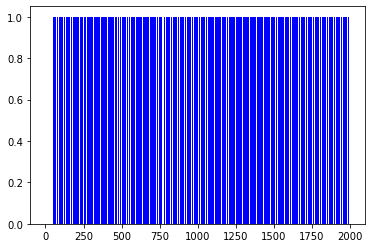

In [4]:
print("Percent of successful episodes: " +str(sum(rList)/num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="b")
plt.show()

In [5]:
sess.close()